# Overview

Here we are simply trying to minimize the root mean square error for predicting the 50th percentile [O/H] from SDSS spectroscopy. Everything in this notebook follows from the previous one.

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
PATH = os.path.abspath('..')

In [3]:
def parse_csv_multi_class_probabilities(path_to_csv):
    """Parse filenames and probabilities for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of probabilities in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    probabilities = [probs for _, *probs in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, probabilities, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, probabilities, idx2class = parse_csv_multi_class_probabilities(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    prob_arr = np.array(probabilities).astype(np.float32)
    
    return full_names, prob_arr, idx2class

In [4]:
@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Initialize network

Let's use the resnet50 this time.

In [5]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [6]:
sz = 32
bs = 64
arch = resnet50

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4, )

In [7]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\John/.torch\models\resnet50-19c8e357.pth
100%|██████████████████████████████████████████████████████████████| 102502400/102502400 [00:07<00:00, 13942474.52it/s]


In [8]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 81%|███████████████████████████████████████████████████████▏            | 973/1200 [00:45<00:10, 21.29it/s, loss=1.73]

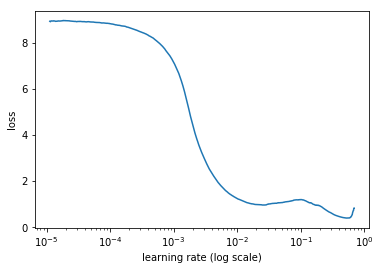

 81%|███████████████████████████████████████████████████████▏            | 973/1200 [01:00<00:13, 16.21it/s, loss=1.73]

In [9]:
learn.lr_find()
learn.sched.plot()

# Begin training

I remember from before that a learning rate of 0.1 seems good...

In [10]:
lr = 0.1
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                                                                                         
    0      0.144944   0.134139  
    1      0.140994   0.129885                                                                                         
    2      0.13661    0.128977                                                                                         


[array([0.12898])]

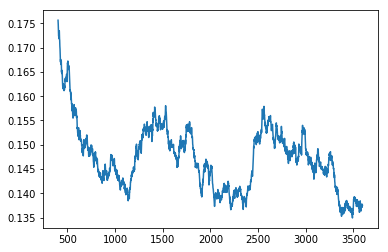

In [14]:
learn.sched.plot_loss(n_skip=400)

## Unfreeze early layers
We'll also lower the training rate slightly

In [15]:
learn.unfreeze()
lrs = 3e-2 * np.array([1/9, 1/3, 1])

learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.104299   0.099176  
    1      0.111203   0.109976                                                                                         
    2      0.101749   0.096193                                                                                         
    3      0.115845   0.149881                                                                                         
    4      0.114905   0.093535                                                                                         
    5      0.103222   0.098746                                                                                         
    6      0.096776   0.091959                                                                                         


[array([0.09196])]

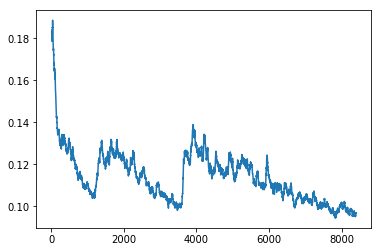

In [16]:
learn.sched.plot_loss()

In [17]:
learn.save('resnet50_32_diff-1')

## Size up to 64x64 
Let's re-freeze + train some

In [ ]:
data = get_data(64, 128)
learn.set_data(data)

learn.freeze()

lr = 3e-2
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

Unfreeze and train more

In [19]:
learn.unfreeze()

lrs = 1e-2 * np.array([1/16, 1/4, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.099298   0.08965   
    1      0.097944   0.092174                                                                                         
    2      0.095455   0.087175                                                                                         
    3      0.102868   0.126358                                                                                         
    4      0.100132   0.106014                                                                                         
    5      0.093405   0.088824                                                                                         
    6      0.089049   0.086275                                                                                         


[array([0.08627])]

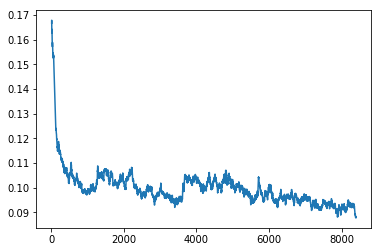

In [20]:
learn.sched.plot_loss()

In [21]:
learn.save('resnet50_32-64_diff-1')

In [ ]:
lrs = 1e-2 * np.array([1/16, 1/4, 1])

learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

  4%|██▌                                                                | 46/1200 [00:09<04:04,  4.72it/s, loss=0.0914]

In [ ]:
learn.sched.plot_loss()